<span style='color:white'>**SAFE@HOME360**</span>

<span style='color:red'>*IOT Enabled Real Time Monitoring of Daily Activities of Elderly People*</span>

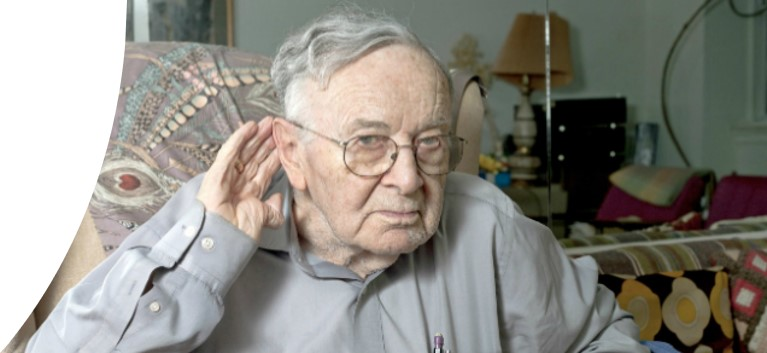

In [1]:
# HOMELIFE360
## IOT Enabled Real Time Monitoring of Elderly People
#![title](Picture1.jpg)

from IPython.display import Image, Markdown, display
import plotly.express as px

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

printmd("**SAFE@HOME360**", color="white")
printmd("*IOT Enabled Real Time Monitoring of Daily Activities of Elderly People*", color ="red")
Image(filename="Picture1.jpg")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from ipywidgets import interactive, interact

import ipywidgets as widgets
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt
import altair as alt
from IPython.display import display, clear_output



df = pd.read_csv('dataset_1.txt',sep=" ", header=None, names=['Date', 'Time', 'Room', 'Signal'])
    #dff = pd.read_csv('data.txt', header=0)
        
#df.columns = ['Date', 'Time', 'Room', 'Signal']
df['time'] =df['Date']+' '+df['Time']
for i in range(len(df)):
    df.time.values[i]=np.datetime64(df.time.values[i])      

In [3]:
scaler = StandardScaler()



def list_dates(df):
    Ti=[]
    s0=np.datetime64(df.Date[0])
    sf=np.datetime64(df.Date[len(df)-1])
    while s0<=sf:
        Ti.append(s0)
        s0=s0+ np.timedelta64(1,'D')
        
    return Ti

    

    

def Time_range(End_date):
    T=[]
    t=End_date-np.timedelta64(30,'D')
    while (t<=End_date):
        T.append(t)
        t=t+np.timedelta64(1,'D')
    return T

def Hours(End_date):
    Day=[]
    Aw=[]
    t3=End_date+np.timedelta64(1,'D')
    t2=End_date
    if (t3>df.time[len(df)-1]):
        t3=df.time[len(df)-1]
    while (t2<=t3):
        Day.append(t2)
        t2=t2+np.timedelta64(1,'h')
    t4=End_date+np.timedelta64(23,'h')
    t1=End_date+np.timedelta64(7,'h')
    if (t4>df.time[len(df)-1]):
        t4=df.time[len(df)-1]
    while (t1<=t4):
        Aw.append(t1)
        t1=t1+np.timedelta64(1,'h')
    return Day, Aw
    




In [9]:


def fit_predict_model(End_date, room):
    m = Prophet(interval_width = 0.9,changepoint_prior_scale=0.3, daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative')
    df_day=pd.DataFrame()
    dataframe=pd.DataFrame()
    df_day=Array(End_date)
    
    dataframe['ds'] = df_day['Date']
    dataframe['y1']=df_day[room]
    dataframe['y']=df_day[room]
    a=dataframe.loc[dataframe['y'] > 10, ['y']]
    dataframe.loc[dataframe['y']<10, 'y']=np.mean(a.y.values)
    
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y1'].reset_index(drop = True)
     
        
    
    return forecast
    
    
def detect_anomalies(End_date, room):
    forecast = fit_predict_model(End_date,room)
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']
    
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    High_activities=forecasted.loc[forecasted['anomaly']==1, ['ds']]
    Low_activities=forecasted.loc[forecasted['anomaly']==-1, ['ds']]
    if len(High_activities)>0:
        if (High_activities['ds'].iloc[len(High_activities)-1]==End_date):
            printmd("*Higher activity than usual yesterday*", color="red")
        elif len(Low_activities)>0:
            if (Low_activities['ds'].iloc[len(Low_activities)-1]==End_date) :
                printmd("*Lower activity than usual yesterday*", color="red")
            else: printmd("*All good yesterday*", color="white")
        else: printmd("*All good yesterday*", color="white")
    elif len(Low_activities)>0:
        if (Low_activities['ds'].iloc[len(Low_activities)-1]==End_date):
            printmd("*Lower activity than usual yesterday*", color="red")
        else: printmd("*All good yesterday*", color="white")
    else: printmd("*All good yesterday*", color="white")
    fig1=px.line(forecasted,x="ds",y="fact",title=room,labels={"ds": "Date","fact": "Number of daily activities"})
    fig1.show()
    return forecasted

def plot_anomalies(End_date, room):
    df_day=Array(End_date)
    a=df_day[room]
    if (a==0).all()==True:
        print('The person have not been to the', room)
    else:
        forecasted = detect_anomalies(End_date, room)
        interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
        x=alt.X('ds:T',  title ='date'),
        y='yhat_upper',
        y2='yhat_lower',
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
        ).interactive().properties(title='Anomalous Activities Signalling Health Concerns')

        fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Number of daily activities'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']).interactive()

        anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Number of daily activities'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)).interactive()
        display(alt.layer(interval, fact, anomalies)\
              .properties(width=700, height=400)\
              .configure_title(fontSize=20))
    
        High_activities=forecasted.loc[forecasted['anomaly']==1, ['ds']]
        Low_activities=forecasted.loc[forecasted['anomaly']==-1, ['ds']]
        if len(High_activities)>0:
            print('Higher activities Dates in',room,':', High_activities)
        if len(Low_activities)>0: 
            print('Lower activities Dates in',room,':', Low_activities)
        
    
    
    #def Dates1(Start_date):
    #    Dates(forecasted)
    #button_4=widgets.Button(description="Anomalous Dates")
    #display(button_4)
    #button_4.on_click(Dates)
    #interval+fact+anomalies
    
                                        


       

    


In [5]:
def Array(End_date):
    Range=Time_range(End_date)
    j=0
    Start_date=End_date-np.timedelta64(30,'D')
    while df.time[j]<=Start_date:
        j=j+1
    p=j-1
    if df.time[0]>Start_date:
        p=0
    O, L, K, B, Be, Tot, D = [], [], [], [], [], [], []
    for i in range(len(Range)):
        a=0
        b=0
        be=0
        k=0
        l=0
        C=0
        d=0
    
        while df.time[p]<=Range[i]:
            p=p+1
        
            if (df.Room.values[p-1]=='Office'):
                if (df.Signal.values[p-1]=='ON'):
                    a=a+1
                else: n=1
                        
            elif (df.Room.values[p-1]=='Bathroom'):
                if (df.Signal.values[p-1]=='ON'):
                            b=b+1  
                else: n=1
                       
            elif df.Room.values[p-1]=='Kitchen':
                if df.Signal.values[p-1]=='ON':
                            k=k+1    
                else: n=1
            elif df.Room.values[p-1]=='LivingRoom':
                if df.Signal.values[p-1]=='ON':
                            l=l+1
                else: n=1
            elif df.Room.values[p-1]=='Bedroom':
                if df.Signal.values[p-1]=='ON':
                            be=be+1
                else: n=1
            elif (df.Room.values[p-1]=='OutsideDoor'):
                if (df.Signal.values[p-1]=='ON'):
                    d=d+1
                    
                else: n=1
            C=a+b+k+l+be                
        
        O.append(a)
        L.append(l)
        K.append(k)
        B.append(b) 
        Be.append(be)
        D.append(d)
        Tot.append(C)
                  
    df_day=pd.DataFrame()
    df_day['Date']=Range
    df_day['Office'] =O
    df_day['cooking']=K
    df_day['bathroom']=B
    df_day['bedroom']=Be
    df_day['Livingroom']=L
    df_day['OutsideDoor']=D
    df_day['Combined']=Tot
    return df_day




           



#Start = st.sidebar.date_input('start date')


#End = st.sidebar.date_input('End date')


#kw=dict(outliers_fraction=(0.01, 0.1,.01),room=['office','cooking','bathroom','bedroom','Livingroom','Combined'], t=('2014-08-11 00:00:00.000', '2014-10-11 00:00:00.000'), tfinal=('2014-08-11 00:00:00.000', '2015-03-11 00:00:00.000'))
#interactive_plot = interact(SVM, outliers_fraction=widgets.FloatSlider(value=0.05, min=0.01, max=0.1, step=0.01), room=['Office','cooking','bathroom','bedroom','Livingroom','Combined'], t=sorted(list(Ti)), tfinal=sorted(list(Tf)))

#interactive_plot     




#Level=widgets.Dropdown(options = ['Day','Time period'], value='Time period', description = 'choose data level', disabled=False)
#display(Level)
#data=str(data)
#display(data)
#def f(x):
#    return x

    




    



In [10]:

def find_ranges(myarray):
    """Yield range of consecutive numbers."""
    sequences = np.split(myarray, np.array(np.where(np.diff(myarray) > 1)[0]) + 1)
    z = []
    for s in sequences:
        if len(s) > 2:
            z.append((np.min(s), np.max(s)))
        else:
            n=1 
    return z
            

def Hourly_activites(End_date,room):
    Range1, Range2=Hours(End_date)
    j=len(df)-1
    while df.time[j]>=End_date:
        j=j-1
    p=j+1
    O, Tot, Dor, T, To = [], [], [], [],[]
    for i in range(len(Range1)):
        a=0
        C=0
    
        while df.time[p]<=Range1[i]:
            p=p+1
        
            if (df.Room.values[p-1]==room):
                if (df.Signal.values[p-1]=='ON'):
                      a=a+1
                else: n=1
                        
            elif (df.Signal.values[p-1]=='ON'):
                C=C+1
        O.append(a)
        Tot.append(C) 
    j=len(df)-1
    while df.time[j]>=(End_date+np.timedelta64(7,'h')):
        j=j-1
    p=j+1    
    for i in range(len(Range2)):
        l=0
        while df.time[p]<=Range2[i]:
            p=p+1
                        
            if (df.Signal.values[p-1]=='ON'):
                l=l+1
               
        T.append(l)
    df_dormant=pd.DataFrame()
    df_dormant['Time']=Range2
    df_dormant['Combined']=T
    #a=df_dormant.loc[df_dormant['Combined']==0,['Time','Combined']]
    k=0
    for i in range(len(df_dormant)):
    
        if df_dormant.Combined.values[i]==0:
            To.append(i)
                
    Ti, Tf=[], []
    a=find_ranges(To)                      
    for i in a:
        for j in i:
            Ti.append(Range2[j])
            Tf.append(0)
        
        
         
    if len(Tf)>0:
        printmd("*He  has not moved > 3hrs: Is he OK??*", color="red")
    df_hours=pd.DataFrame()
    
   # df_hours['Time'] = pd.to_datetime(Range1)
    #df_hours['Time']=df_hours['Time'].dt.hour
    df1=pd.DataFrame()
    df2=pd.DataFrame()
    df1['T1']=Tf[0:2]
    df1['Date1']=Ti[0:2]
    df2['T2']=Tf[2:4]
    df2['Date2']=Ti[2:4]
    df_hours['Time']=Range1
    df_hours[room] = O
    df_hours['Combined']=Tot
    fig1=px.line(df_hours,x="Time",y=room,title=room,labels={"Time": "Hours after 12AM",room: "Hourly activities in a day"})
   # fig1=px.line(df1,x="Date1",y="T1",title=room,labels={"Date1": "Hours after 12AM","T1": "Hourly activities in a day"})
    fig1.add_scatter(x=df1['Date1'], y=df1['T1'],mode='lines',name="Has not moved")
    fig1.add_scatter(x=df2['Date2'], y=df2['T2'],mode='lines',name="Has not moved")
    fig1.show()

Ti=list_dates(df)
    
#def fun2(Hourly_activities):
   # clear_output()
    #display(widgets.HBox((button_1, button_2, button_3)))
tab=widgets.Tab()
#tab.children=(button1)
tab.set_title(0,'Raw data')
tab.set_title(1,'Month')
tab.set_title(2,'Day')

print("Month: Activities coresponding from a month before the current date")

    
interactive_plot1 = interactive(Hourly_activites, End_date=widgets.Dropdown(options=sorted(list(Ti), reverse= True), description='Current date'), room=widgets.Dropdown(options=['Bedroom','Kitchen','Bathroom','LivingRoom','Office','OutsideDoor','Combined'], value='Bedroom',description='Choose room', disabled=False))
    

#def fun1(detect_anomalies):
    #clear_output()
    #display(widgets.HBox((button_1, button_2, button_3)))
    #Ti=list_dates()
    #printmd("*Dates in YYYY-MM-DD*", color="red")
interactive_plot=interactive(plot_anomalies,End_date=widgets.Dropdown(options=sorted(list(Ti), reverse= True), description='Current date'), room=widgets.Dropdown(options=['bedroom','cooking','bathroom','Livingroom','Office','OutsideDoor','Combined'], description='Choose room'))  
    
def f(x):
    print(df.head(x))
#def show_articles_more_than(x):
   # clear_output()
   # display(widgets.HBox((button_1, button_2, button_3)))
f1= interactive(f, x=widgets.IntSlider(min=5, max=1000, step=1, value=10))
                             
tab.children = [widgets.VBox(children = f1.children), widgets.VBox(children = interactive_plot.children),widgets.VBox(children = interactive_plot1.children)]

display(tab)
    
#button_1 = widgets.Button(description="Month")
#button_2 = widgets.Button(description="Day")
#button_3=widgets.Button(description="Raw data")



#display(widgets.HBox((button_3,button_1, button_2)))

#button_1.on_click(fun1)

#button_2.on_click(fun2)

#button_3.on_click(show_articles_more_than)

#output = widgets.Output()








#display(widgets.HBox((button_1, button_2, button_3)))

#out = widgets.Output()
#display(out)

#def on_button_clicked(b):
 #   with out:
 #       out.clear_output()
  #     print("Button clicked.")

#button_1.on_click(on_button_clicked)
#button_2.on_click(on_button_clicked)
#button_3.on_click(on_button_clicked)

#tab=widgets.Tab()
#tab.children=[button_1,button_2]
#tab.set_title(0,'Select time period')
#tab.set_title(1,'Day')
#display(tab)


Month: Activities coresponding from a month before the current date
